In [1]:


import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
file_path = '../datasets/riemann_training_data_balanced2.csv'

df = pd.read_csv(file_path)

# Select category
df = df[df['category'] != 8]

In [4]:
# df.head()

In [4]:
g = 9.806
df['uL'] = df['huL'] / df['hL']
df['uR'] = df['huR'] / df['hR']
df['cL'] = (df['hL'] * g) ** 0.5
df['cR'] = (df['hR'] * g) ** 0.5

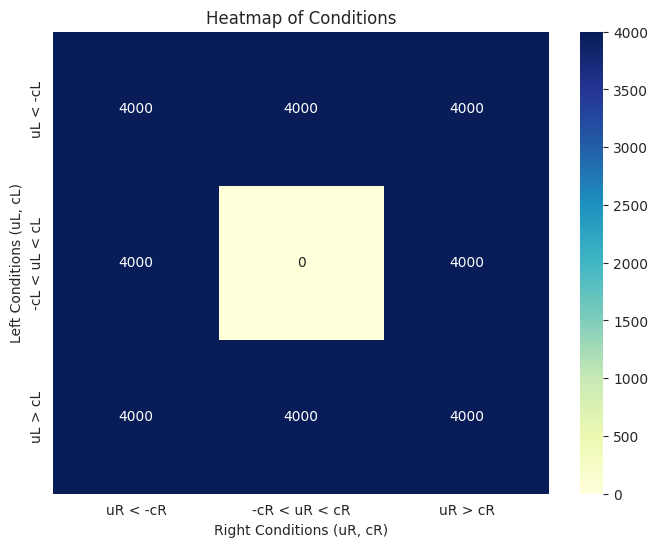

In [5]:
# Assuming `df` is your DataFrame
# Define the conditions for rows (uL, cL) and columns (uR, cR)
row_conditions = [
    df['uL'] < -df['cL'],
    (df['uL'] >= -df['cL']) & (df['uL'] <= df['cL']),
    df['uL'] > df['cL']
]

col_conditions = [
    df['uR'] < -df['cR'],
    (df['uR'] >= -df['cR']) & (df['uR'] <= df['cR']),
    df['uR'] > df['cR']
]

# Create a 3x3 matrix to store counts
heatmap_data = np.zeros((3, 3))

# Calculate counts for each combination of conditions
for i, row_cond in enumerate(row_conditions):
    for j, col_cond in enumerate(col_conditions):
        heatmap_data[i, j] = df[row_cond & col_cond].shape[0]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", xticklabels=['uR < -cR', '-cR < uR < cR', 'uR > cR'], yticklabels=['uL < -cL', '-cL < uL < cL', 'uL > cL'])
plt.title("Heatmap of Conditions")
plt.xlabel("Right Conditions (uR, cR)")
plt.ylabel("Left Conditions (uL, cL)")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Define input features and output features
X = df[['hL', 'huL', 'hR', 'huR']]
# X['ghL'] = np.sqrt(9.8066 * df['hL'])
# X['ghR'] = np.sqrt(9.8066 * df['hR'])
y = df[['h_star', 'u_star']]

# Split the data into training and validation sets
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['category'])

print(f"Training input shape: {train_X.shape}")
print(f"Validation input shape: {val_X.shape}")
print(f"Training output shape: {train_y.shape}")
print(f"Validation output shape: {val_y.shape}")

Training input shape: (25600, 4)
Validation input shape: (6400, 4)
Training output shape: (25600, 2)
Validation output shape: (6400, 2)


In [5]:
# Convert pandas DataFrames to PyTorch tensors
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
val_X_tensor = torch.tensor(val_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 25600
Validation dataset size: 6400


In [6]:
train_dataset[3]

(tensor([3.3876, 1.6469, 0.3550, 4.0428]), tensor([0.1211, 9.8344]))

In [7]:
hL, huL, hR, huR = map(lambda x: x.item(), train_dataset[3][0])

In [10]:
uR = huR / hR
uL = huL / hL

In [11]:
uL

0.4861547043502747

In [8]:
from simulation import Simulation
from training.solvers import CabaretSolverPlus, RiemannSolver

config = {
    'L': 10,
    'nx': 80,

    'h_l': hL,
    'h_r': hR,
    'u_l': huL / hL,
    'u_r': huR / hR,

    'solver': CabaretSolverPlus(model=None),
    't_end': 0.2,
    't_start': 0.0,
}

sim = Simulation(config)

Cabaret solver:  classic


In [ ]:
sim.run()

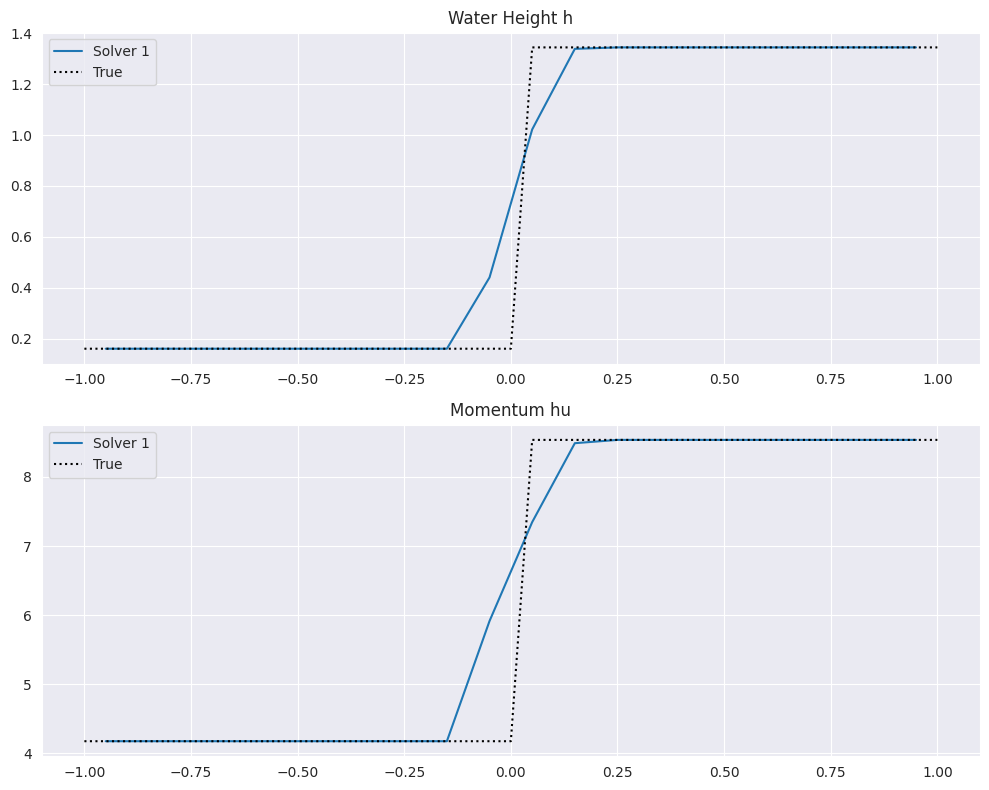

In [86]:
from simulation import plot_comparison

plot_comparison(sim)

In [ ]:
sim.plot()

In [16]:
sim.solver.h_node_n

array([2.5377939, 2.5377939, 2.5377939, 2.5377939, 2.5377939, 2.5377939,
       2.5377939, 2.5377939, 2.5377939, 2.5377939, 2.0091596, 1.4805254,
       1.4805254, 1.4805254, 1.4805254, 1.4805254, 1.4805254, 1.4805254,
       1.4805254, 1.4805254, 1.4805254], dtype=float32)

In [17]:
n = sim.solver.h_node_n.shape[0]

sim.solver.h_node_n[n//2-3:n//2+3+1]

array([2.5377939, 2.5377939, 2.5377939, 2.0091596, 1.4805254, 1.4805254,
       1.4805254], dtype=float32)

In [18]:
sim.solver.h_node_n_plus_1_char

array([2.53779387, 2.53779375, 2.53779375, 2.53779375, 2.53779375,
       2.53779375, 2.53779375, 2.53779375, 2.53779375, 2.42947201,
       1.91659473, 1.11211804, 1.48052533, 1.48052533, 1.48052533,
       1.48052533, 1.48052533, 1.48052533, 1.48052533, 1.48052533,
       1.48052537])

In [19]:
m = sim.solver.h_cell_n.shape[0]

sim.solver.h_cell_n[m // 2 - 3 : m // 2 + 3]

array([2.5377939, 2.5377939, 2.2734766, 1.7448425, 1.4805254, 1.4805254],
      dtype=float32)

In [145]:
# Create an empty DataFrame with columns and a labeled index
columns = ['I1_node_n[j-1]', 'I1_node_n[j]', 'I1_node_n[j+1]', 'I2_node_n[j-1]', 'I2_node_n[j]', 'I2_node_n[j+1]',
           'I1_cell_n_plus_half[j-1]', 'I1_cell_n_plus_half[j]', 'I2_cell_n_plus_half[j-1]', 'I2_cell_n_plus_half[j]',
           'I1_cell_n[j-1]', 'I1_cell_n[j]', 'I2_cell_n[j-1]', 'I2_cell_n[j]',
           'I1_node_n_plus_1[j]', 'I2_node_n_plus_1[j]',
          'I1_cell_n_plus_1[i - 1]', 'I2_cell_n_plus_1[i - 1]',
           'I1_cell_n_plus_1[i]', 'I2_cell_n_plus_1[i]']
new_df = pd.DataFrame(columns=columns)

new_df

,I1_node_n[j-1],I1_node_n[j],I1_node_n[j+1],I2_node_n[j-1],I2_node_n[j],I2_node_n[j+1],I1_cell_n_plus_half[j-1],I1_cell_n_plus_half[j],I2_cell_n_plus_half[j-1],I2_cell_n_plus_half[j],I1_cell_n[j-1],I1_cell_n[j],I2_cell_n[j-1],I2_cell_n[j],I1_node_n_plus_1[j],I2_node_n_plus_1[j],I1_cell_n_plus_1[i - 1],I2_cell_n_plus_1[i - 1],I1_cell_n_plus_1[i],I2_cell_n_plus_1[i]


In [134]:
n_features = 14

# Create column names
columns_A = [f'f{i+1}_A' for i in range(n_features)]
columns_B = [f'f{i+1}_B' for i in range(n_features)]

# Create an empty DataFrame with columns and a labeled index
columns = ['I1_node_n[j-1]', 'I1_node_n[j]', 'I1_node_n[j+1]', 'I2_node_n[j-1]', 'I2_node_n[j]', 'I2_node_n[j+1]',
           'I1_cell_n_plus_half[j-1]', 'I1_cell_n_plus_half[j]', 'I2_cell_n_plus_half[j-1]', 'I2_cell_n_plus_half[j]',
           'I1_cell_n[j-1]', 'I1_cell_n[j]', 'I2_cell_n[j-1]', 'I2_cell_n[j]',
           'I1_node_n_plus_1[j]', 'I2_node_n_plus_1[j]',
           'I1_node_true', 'I2_node_true']

# Build DataFrame
new_df = pd.DataFrame(
    # columns=columns_A + columns_B + ['h_true'] + ['hu_true'] + ['dt']
    columns=columns
)

new_df

,I1_node_n[j-1],I1_node_n[j],I1_node_n[j+1],I2_node_n[j-1],I2_node_n[j],I2_node_n[j+1],I1_cell_n_plus_half[j-1],I1_cell_n_plus_half[j],I2_cell_n_plus_half[j-1],I2_cell_n_plus_half[j],I1_cell_n[j-1],I1_cell_n[j],I2_cell_n[j-1],I2_cell_n[j],I1_node_n_plus_1[j],I2_node_n_plus_1[j],I1_node_true,I2_node_true


In [110]:
def run_sim(hL, huL, hR, huR):
    config = {
    'L': 1,
    'nx': 20,

    'h_l': hL,
    'h_r': hR,
    'u_l': huL / hL,
    'u_r': huR / hR,

    'solver': CabaretSolverPlus(model=None),
    't_end': 5e-3,
    't_start': 0,
    }

    sim = Simulation(config)
    sim.run()

    print(len(sim.x))
    print(sim.t)

    true_solver = RiemannSolver()
    h, u = true_solver.solve(sim.x, sim.t, config['h_l'], config['u_l'], config['h_r'], config['u_r'])['vals']

    return sim, (h, u)

In [144]:
def get_data(solver, target):
    g = solver.g

    window = 1

    node_count = solver.h_node_n.shape[0]
    h_node_n = solver.h_node_n[node_count//2 - window : node_count//2 + window + 1]
    hu_node_n = solver.hu_node_n[node_count//2 - window : node_count//2 + window + 1]

    # Calculate u, c, I1, I2 at nodes at time n.
    u_node_n = hu_node_n / (h_node_n + 1e-12)
    c_node_n = np.sqrt(g * np.maximum(0.0, h_node_n))

    # Using Riemann invariants as defined in the paper for extrapolation.
    I1_node_n = u_node_n + c_node_n
    I2_node_n = u_node_n - c_node_n

    # ----------

    cell_count = solver.h_cell_n.shape[0]
    h_cell_n = solver.h_cell_n[cell_count//2 - window : cell_count//2 + window]
    hu_cell_n = solver.hu_cell_n[cell_count//2 - window : cell_count//2 + window]

    # Calculate u, c, I1, I2 at cell centers at time n (for nonlinear correction bounds).
    u_cell_n = hu_cell_n / (h_cell_n + 1e-12)
    c_cell_n = np.sqrt(g * np.maximum(0.0, h_cell_n))

    # Using Riemann invariants as defined in the paper for bounds.
    I1_cell_n = u_cell_n + c_cell_n
    I2_cell_n = u_cell_n - c_cell_n

    # ----------

    h_cell_n_plus_half = solver.h_cell_n_plus_half[cell_count//2 - window : cell_count//2 + window]
    hu_cell_n_plus_half = solver.hu_cell_n_plus_half[cell_count//2 - window : cell_count//2 + window]

    # Calculate u, c, I1, I2 (Riemann invariants) at cell centers at n+1/2.
    u_cell_n_plus_half = hu_cell_n_plus_half / (h_cell_n_plus_half + 1e-12)
    c_cell_n_plus_half = np.sqrt(g * np.maximum(0.0, h_cell_n_plus_half))

    I1_cell_n_plus_half = u_cell_n_plus_half + c_cell_n_plus_half
    I2_cell_n_plus_half = u_cell_n_plus_half - c_cell_n_plus_half

    # ----------

    h_node_n_plus_1_char = solver.h_node_n_plus_1_char[node_count//2 - window : node_count//2 + window + 1]
    hu_node_n_plus_1_char = solver.hu_node_n_plus_1_char[node_count//2 - window : node_count//2 + window + 1]

    # Calculate u, c, I1, I2 at nodes at time n + 1.
    u_node_n_plus_1_char = hu_node_n_plus_1_char / (h_node_n_plus_1_char + 1e-12)
    c_node_n_plus_1_char = np.sqrt(g * np.maximum(0.0, h_node_n_plus_1_char))

    I1_node_n_plus_1 = u_node_n_plus_1_char + c_node_n_plus_1_char
    I2_node_n_plus_1 = u_node_n_plus_1_char - c_node_n_plus_1_char

    # print(h_node_n)
    # print(h_cell_n)
    # print(h_cell_n_plus_half)
    # print(h_node_n_plus_1_char)

    h, u = target
    h_node_true = h[::2][node_count//2 - window:node_count//2 + window + 1]
    u_node_true = u[::2][node_count//2 - window:node_count//2 + window + 1]

    # Calculate true u, c, I1, I2 at nodes at time n + 1.
    c_node_true = np.sqrt(g * np.maximum(0.0, h_node_true))

    I1_node_true = u_node_true + c_node_true
    I2_node_true = u_node_true - c_node_true

    h_cell_n_plus_1_char = solver.h_cell_n_plus_1[cell_count//2 - window:cell_count//2 + window]
    hu_cell_n_plus_1_char = solver.hu_cell_n_plus_1[cell_count//2 - window:cell_count//2 + window]

    # Calculate u, c, I1, I2 at cell at time n + 1.
    u_cell_n_plus_1_char = hu_cell_n_plus_1_char / (h_cell_n_plus_1_char + 1e-12)
    c_cell_n_plus_1_char = np.sqrt(g * np.maximum(0.0, h_cell_n_plus_1_char))

    I1_cell_n_plus_1 = u_cell_n_plus_1_char + c_cell_n_plus_1_char
    I2_cell_n_plus_1 = u_cell_n_plus_1_char - c_cell_n_plus_1_char

    # print(I1_cell_n_plus_1)
    # print(I1_node_n_plus_1)
    # print(I1_node_true)

    h_cell_true = h[1::2][cell_count//2 - window:cell_count//2 + window]
    u_cell_true = u[1::2][cell_count//2 - window:cell_count//2 + window]

    # Calculate true u, c, I1, I2 at nodes at time n + 1.
    c_cell_true = np.sqrt(g * np.maximum(0.0, h_cell_true))

    I1_cell_true = u_cell_true + c_cell_true
    I2_cell_true = u_cell_true - c_cell_true

    # print(I1_cell_true)

    assert (len(h_node_true) == len(h_node_n))

    for i in range(1, len(h_node_n) - 1):
        # print(h_cell_n[i - 1], h_node_n[i], h_cell_n[i])

        node_n = (I1_node_n[i - 1 : i + 2], I2_node_n[i - 1 : i + 2])
        cell_n = (I1_cell_n[i - 1 : i + 1], I2_cell_n[i - 1 : i + 1])
        cell_n_plus_half = (I1_cell_n_plus_half[i - 1 : i + 1], I2_cell_n_plus_half[i - 1 : i + 1])
        target = (I1_node_n_plus_1[i], I2_node_n_plus_1[i])

        # print(node_n, cell_n, cell_n_plus_half, target)


        new_df.loc[len(new_df)] = [I1_node_n[i - 1], I1_node_n[i], I1_node_n[i + 1], I2_node_n[i - 1], I2_node_n[i], I2_node_n[i + 1],
                                   I1_cell_n_plus_half[i - 1], I1_cell_n_plus_half[i], I2_cell_n_plus_half[i - 1], I2_cell_n_plus_half[i],
                                   I1_cell_n[i - 1], I1_cell_n[i], I2_cell_n[i - 1], I2_cell_n[i],
                                   I1_node_n_plus_1[i], I2_node_n_plus_1[i],
                                   I1_cell_true[i - 1], I2_cell_true[i - 1],
                                   I1_cell_true[i], I2_cell_true[i]
                                   ]

In [112]:
def get_data2(solver, target):
    g = solver.g

    window = 1

    node_count = solver.h_node_n.shape[0]
    h_node_n = solver.h_node_n[node_count//2 - window : node_count//2 + window + 2]
    hu_node_n = solver.hu_node_n[node_count//2 - window : node_count//2 + window + 2]

    # Calculate u, c, I1, I2 at nodes at time n.
    u_node_n = hu_node_n / (h_node_n + 1e-12)
    c_node_n = np.sqrt(g * np.maximum(0.0, h_node_n))

    # Using Riemann invariants as defined in the paper for extrapolation.
    I1_node_n = u_node_n + c_node_n
    I2_node_n = u_node_n - c_node_n

    # ----------

    cell_count = solver.h_cell_n.shape[0]
    h_cell_n = solver.h_cell_n[cell_count//2 - window : cell_count//2 + window + 1]
    hu_cell_n = solver.hu_cell_n[cell_count//2 - window : cell_count//2 + window + 1]

    # Calculate u, c, I1, I2 at cell centers at time n (for nonlinear correction bounds).
    u_cell_n = hu_cell_n / (h_cell_n + 1e-12)
    c_cell_n = np.sqrt(g * np.maximum(0.0, h_cell_n))

    # Using Riemann invariants as defined in the paper for bounds.
    I1_cell_n = u_cell_n + c_cell_n
    I2_cell_n = u_cell_n - c_cell_n

    # ----------

    h_cell_n_plus_half = solver.h_cell_n_plus_half[cell_count//2 - window : cell_count//2 + window + 1]
    hu_cell_n_plus_half = solver.hu_cell_n_plus_half[cell_count//2 - window : cell_count//2 + window + 1]

    # Calculate u, c, I1, I2 (Riemann invariants) at cell centers at n+1/2.
    u_cell_n_plus_half = hu_cell_n_plus_half / (h_cell_n_plus_half + 1e-12)
    c_cell_n_plus_half = np.sqrt(g * np.maximum(0.0, h_cell_n_plus_half))

    # Using Riemann invariants as defined in the paper (below Eq. 7, page 4): I1 = u + c, I2 = u - c
    I1_cell_n_plus_half = u_cell_n_plus_half + c_cell_n_plus_half
    I2_cell_n_plus_half = u_cell_n_plus_half - c_cell_n_plus_half

    # ----------

    h_node_n_plus_1_char = solver.h_node_n_plus_1_char[node_count//2 - window : node_count//2 + window + 2]
    hu_node_n_plus_1_char = solver.hu_node_n_plus_1_char[node_count//2 - window : node_count//2 + window + 2]

    # Calculate u, c, I1, I2 at nodes at time n + 1.
    u_node_n_plus_1_char = hu_node_n_plus_1_char / (h_node_n_plus_1_char + 1e-12)
    c_node_n_plus_1_char = np.sqrt(g * np.maximum(0.0, h_node_n_plus_1_char))

    # Using Riemann invariants as defined in the paper for extrapolation.
    I1_node_n_plus_1 = u_node_n_plus_1_char + c_node_n_plus_1_char
    I2_node_n_plus_1 = u_node_n_plus_1_char - c_node_n_plus_1_char

    # print(h_node_n)
    # print(h_cell_n)
    # print(h_cell_n_plus_half)
    # print(h_node_n_plus_1_char)

    h, u = target
    h_cell_true = h[1::2][cell_count//2 : cell_count//2 + 1]
    u_cell_true = u[1::2][cell_count//2 : cell_count//2 + 1]
    # Calculate true u, c, I1, I2 at nodes at time n + 1.
    # c_node_true = np.sqrt(g * np.maximum(0.0, h_cell_true))
    hu_cell_true = h_cell_true * u_cell_true

    # Using Riemann invariants as defined in the paper for extrapolation.
    # I1_node_true = u_cell_true + c_node_true
    # I2_node_true = u_cell_true - c_node_true


    h_cell_n_plus_1 = solver.h_cell_n_plus_1[cell_count//2 : cell_count//2 + 1]
    hu_cell_n_plus_1 = solver.hu_cell_n_plus_1[cell_count//2 : cell_count//2 + 1]


    # assert (len(h_cell_true) == len(h_node_n))

    # print(len(h_cell_true), len(h_node_n))
    # print(len(I1_node_n), len(I1_cell_n))

    # print(h_cell_n_plus_1, hu_cell_n_plus_1)

    feats = [0] * 2

    # print(h_cell_n_plus_half)
    # print(h_cell_true)

    for i in range(len(h_cell_true) + 1):
        # print(h_cell_n[i - 1], h_node_n[i], h_cell_n[i])

        # node_n = (I1_node_n[i - 1 : i + 2], I2_node_n[i - 1 : i + 2])
        # cell_n = (I1_cell_n[i - 1 : i + 1], I2_cell_n[i - 1 : i + 1])
        # cell_n_plus_half = (I1_cell_n_plus_half[i - 1 : i + 1], I2_cell_n_plus_half[i - 1 : i + 1])
        # target = (I1_node_n_plus_1[i], I2_node_n_plus_1[i])

        # print(node_n, cell_n, cell_n_plus_half, target)


        feats[i] = [I1_node_n[i - 1], I1_node_n[i], I1_node_n[i + 1], I2_node_n[i - 1], I2_node_n[i], I2_node_n[i + 1],
                                   I1_cell_n_plus_half[i - 1], I1_cell_n_plus_half[i], I2_cell_n_plus_half[i - 1], I2_cell_n_plus_half[i],
                                   I1_cell_n[i - 1], I1_cell_n[i], I2_cell_n[i - 1], I2_cell_n[i],
                                   # I1_node_n_plus_1[i], I2_node_n_plus_1[i],
                                   ]

    sample = np.hstack([*feats, h_cell_true[0] - h_cell_n_plus_half[1], hu_cell_true[0] - hu_cell_n_plus_half[1], solver.dt])
    new_df.loc[len(new_df)] = sample
    # print(sample.shape, sample)

In [ ]:
for i, episode in enumerate(train_X_tensor[:]):
    # print(i, episode)

    hL, huL, hR, huR = map(lambda x: x.item(), episode)
    sim, target = run_sim(hL, huL, hR, huR)
    solver = sim.solver
    # plot_comparison(sim, ['asd'], plot_solution=True)
    # sim.plot()

    get_data(solver, target)

In [120]:
new_df

,f1_A,f2_A,f3_A,f4_A,f5_A,f6_A,f7_A,f8_A,f9_A,f10_A,...,f8_B,f9_B,f10_B,f11_B,f12_B,f13_B,f14_B,h_true,hu_true,dt
0,5.391953,-0.362757,1.837919,-6.835221,-5.953291,-6.941813,5.296203,0.945157,-6.866187,-5.945422,...,3.869945,-5.945422,-6.799355,1.063550,4.043365,-5.729356,-6.645656,0.909388,1.500258,0.002727
1,5.391953,-0.362757,1.837919,-6.835221,-5.953291,-6.941813,5.296203,0.945157,-6.866187,-5.945422,...,3.869945,-5.945422,-6.799355,1.063550,4.043365,-5.729356,-6.645656,0.909388,1.500258,0.002727
2,5.859935,-1.155332,2.556248,-8.628891,-9.036711,-9.117175,5.719871,1.426470,-8.674722,-8.639402,...,4.167922,-8.639402,-8.860258,1.575504,4.368553,-8.383178,-8.707083,1.024694,2.742843,0.003290


In [139]:
len(new_df)

25600

In [147]:
file_path = 'datasets/new_riemann_5.csv'
new_df.to_csv(file_path, index=False)

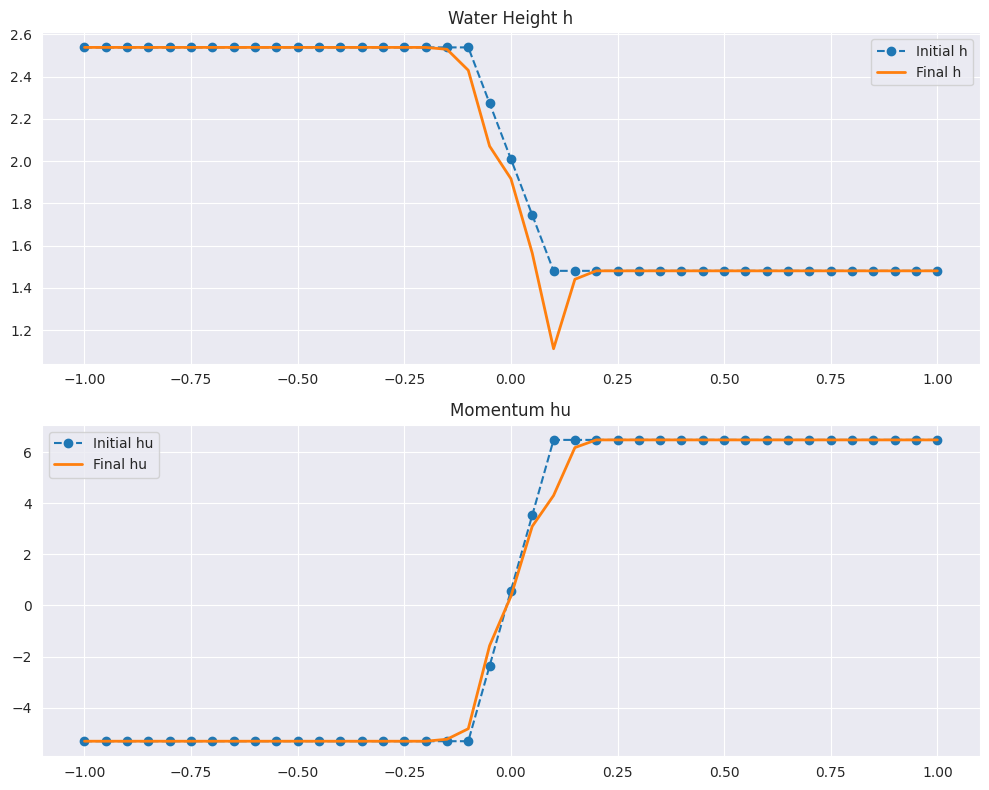

In [51]:
sim.plot()